# Capítulo 3 - Cuaderno extra

Un conocido carpintero de barcos quiere recrear unos barcos que ha visto por internet y dispone de varias imágenes de referencia para poder tomar medidas aproximadas.

El problema viene cuando empieza a tomar medidas en las propias imágenes y se distrae entre tanto color y sus propias medidas. Al final, toma medidas redundantes y tarda mucho en tener un plano decente. 

Este carpintero nos ha contratado para que cojamos cada una de sus imágenes y las procesemos de forma que solo tengan el contenido importante (los bordes), para que él pueda dibujar sobre ellas sin distraerse.

<div style="display:flex; justify-content:center">
	<img src= "./images/Carpintero.jpg">
</div>


Para ello, vamos a usar los algoritmos que hemos visto en el **capítulo 3** y encontrar sus **mejores parámetros** para que todos encuentren los bordes de la mejor forma posible. 

Una vez que tengamos esos algoritmos implementados, nos quedaremos con el que nos dé mejor resultado.

In [69]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interactive, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

images_path = './images/'

## Implementación de las funciones

Primero vamos a implementar funciones que apliquen los distintos algoritmos a nuestra imágen.

### Gradiente de la imagen
Podemos aproximar el gradiente de la imagen con la suma del valor absoluto de sus convoluciones con un kernel dado, nosotros usaremos Sobel, ya que es el más usado.
$$|\nabla F(x,y)| = \sqrt{(F \otimes G_C)^2 + (F \otimes G_R)^2} \approx |F \otimes G_C| + |F \otimes G_R|$$

In [70]:
def edge_detection_chart(image, kernel_h, kernel_v, threshold):
    """ Computed the gradient of the image, binarizes and display it.   
    
        Args:
            image: Input image
            kernel_h: kernel for horizontal derivative
            kernel_v: kernel for vertical derivative
            threshold: threshold value for binarization
            
        Returns:
            result: edges binary image
    """
    # Compute derivatives
    d_h = cv2.filter2D(image, cv2.CV_16S, kernel_h)
    d_v = cv2.filter2D(image, cv2.CV_16S, kernel_v)

    # Compute gradient
    gradient_image = np.absolute(d_h) + np.absolute(d_v)
    
    #Normalize gradient
    norm_gradient = cv2.normalize(gradient_image, None, 0, 255, cv2.NORM_MINMAX)

    # Threshold to get edges
    ret, result = cv2.threshold(norm_gradient, threshold, 255, cv2.THRESH_BINARY)
    
    return result

### Operador DroG

El algoritmo anterior tenía un problema, el ruido afecta mucho al gradiente. El operador DroG corrige eso haciendo la convolución con un **kernel Gaussiano**.

$$g_{\sigma}(x,y) = \frac{1}{2\pi\sigma^2}exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)$$

$$
\nabla [f(x,y)\otimes g_\sigma(x,y)] = 
f(x,y) \otimes \nabla [g_\sigma(x,y)] = 
f(x,y) \otimes \text{DroG} (x,y)
$$

$$
DroG(x,y) = 
\nabla \left[ g_\sigma (x,y) \right] = 
\underbrace{\begin{bmatrix} 
\frac{\partial}{\partial x}[g_\sigma(x)g_\sigma(y)] \\ 
\frac{\partial}{\partial y}[g_\sigma(x)g_\sigma(y)] \end{bmatrix}}_{\text{separability}} = 
\underbrace{\begin{bmatrix} \frac{-xg_\sigma(x)g_\sigma(y)}{\sigma^2} \\ \frac{-yg_\sigma(x)g_\sigma(y)}{\sigma^2}\end{bmatrix}}_{g(x)'=-xg(x)/\sigma^2} = 
\begin{bmatrix} \frac{-xg_\sigma(x,y)}{\sigma^2} \\ \frac{-yg_\sigma(x,y)}{\sigma^2}\end{bmatrix}
$$

In [71]:
def drog_kernel(image, w_kernel, sigma, threshold):
    """ Construct the DroG operator and call edge_detection_chart.   
    
        Args:
            image: Input image
            w_kernel: Kernel aperture size
            sigma: Standard deviation of the Gaussian distribution
            threshold: Threshold value for binarization
            
        Returns:
            result: edges binary image
    """
    # Create the 1D gaussian filter
    s = sigma
    w = w_kernel
    gaussian_kernel_1D = np.array([1 / (s*np.sqrt(2*np.pi)) * np.exp(-(z**2)/(2*s**2)) for z in range(-w,w+1)])
    
    # Get the 2D gaussian filter from the 1D one.
    vertical_kernel = gaussian_kernel_1D.reshape(2*w+1,1)
    horizontal_kernel = gaussian_kernel_1D.reshape(1,2*w+1)
    gaussian_kernel_2D = signal.convolve2d(horizontal_kernel, vertical_kernel)
    
    # Construct DroG
    x = np.arange(-w,w+1)
    y = np.vstack(x)

    # Get the kernels for detecting horizontal and vertical edges
    DroG_h = gaussian_kernel_2D * (-x) / (sigma**2)
    DroG_v = y * (-gaussian_kernel_2D) / (sigma**2)

    # Call edge detection chart using DroG
    result = edge_detection_chart(image, DroG_h, DroG_v, threshold)

    return result

### Operador LoG
Este algoritmo aplica a la imagen un desenfoque gaussiano y luego aplicar el operador **laplaciano**. Los inconvenientes de este algoritmo son que es computacionalmente **muy costoso** y además necesita de un algoritmo de paso por cero para que funcione.

In [72]:
def gaussian_smoothing(image, sigma, w_kernel):
    """ Blur and normalize input image.   
    
        Args:
            image: Input image to be binarized
            sigma: Standard deviation of the Gaussian distribution
            w_kernel: Kernel aperture size
                    
        Returns: 
            smoothed_norm: Blurred image
    """   
    # Define 1D kernel
    s=sigma
    w=w_kernel
    kernel_1D = np.array([1 / (s*np.sqrt(2*np.pi)) * np.exp(-(z**2)/(2*s**2)) for z in range(-w,w+1)])
    
    # Apply distributive property of convolution
    vertical_kernel = kernel_1D.reshape(2*w+1,1)
    horizontal_kernel = kernel_1D.reshape(1,2*w+1)   
    gaussian_kernel_2D = signal.convolve2d(horizontal_kernel, vertical_kernel)   
    
    # Blur image
    # NO hace falta usar cv2.CV_16 porque el kernel es positivo y suma 1, no hay overflow
    smoothed_img = cv2.filter2D(image, -1, gaussian_kernel_2D)
    
    # Normalize to [0, 254] values
    smoothed_norm = cv2.normalize(smoothed_img, None, 0, 254, cv2.NORM_MINMAX)

    return smoothed_norm

def apply_laplacian(image, size_Laplacian, sigma, w_gaussian):
    """ Apply Laplacian and Log operators to an image.   
    
        Args:
            image: Input image to be binarized
            size_Laplacian: size of Laplacian kernel (odd)
            sigma: Standard deviation of the Gaussian distribution
            w_gaussian: Gaussian kernel aperture size
        
        Returns:
			result: Return the edges binary image 
    """
    # Blur image
    blurred_img = gaussian_smoothing(image, sigma, w_gaussian)

    # Apply Laplacian to the blurred image
    laplacian_blurred = cv2.Laplacian(blurred_img, cv2.CV_64F, ksize=size_Laplacian)

    return laplacian_blurred

# This function takes an image, applies LoG (in reality, Gaussian and then laplacian) and then, a Zero-Crossing algorithm.
# It will show the original image, the image with LoG and the image with Zero-Crossing applied.
def zero_crossing(image, size_Laplacian, sigma, w_gaussian, threshold):

    laplacian = apply_laplacian(image, size_Laplacian, sigma, w_gaussian)
    
    laplacian_blurred = cv2.normalize(laplacian, None, -255, 255, cv2.NORM_MINMAX)
    
    width, height = laplacian_blurred.shape
    edges = np.zeros_like(laplacian_blurred,np.uint8)

    for x in range(1,width-1):
        for y in range(1,height-1):
            neighbors = [
                laplacian_blurred[x-1, y-1], laplacian_blurred[x, y-1], laplacian_blurred[x+1, y-1],
                laplacian_blurred[x-1, y],                              laplacian_blurred[x+1, y], 
                laplacian_blurred[x-1, y+1], laplacian_blurred[x, y+1], laplacian_blurred[x+1, y+1]
            ]
        
            if(laplacian_blurred[x,y] > threshold and any(n < -threshold for n in neighbors)) or (laplacian_blurred[x,y] < -threshold and any(n > threshold for n in neighbors)):
                edges[x,y] = 255

    return edges

### Algoritmo de Canny
Este algoritmo aplica **Derivadas de Gaussiana (DroG)** para obtener la magnitud y dirección del gradiente, luego realiza **supresión no máxima** comparando cada píxel con sus vecinos en la dirección del gradiente para evitar falsos positivos. Finalmente usa **doble umbral** y **histéresis**: mantiene bordes fuertes y solo conserva los débiles si están conectados a ellos, reduciendo así el ruido y posibles bordes sueltos. 

En este caso usaremos el algoritmo de Canny sin suavizar la imágen porque estas no tienen ruido y si las suavizamos, detecta peor los bordes.

In [73]:
def canny_testing(image, lower_threshold, upper_threshold, sigma, w_gaussian):
    """ Apply Canny algorithm to an image.   
    
        Args:
            image: Input image to be processed
            lower_threshold: bottom value for hysteresis
            upper_threshold: top value for hysteresis
            sigma: Standard deviation of the Gaussian distribution
            w_gaussian: Gaussian kernel aperture size
            
        Returns:
            result: Canny edges binary image
    """  
    # Apply Canny to blurred image
    result = cv2.Canny(image, lower_threshold, upper_threshold)
    
    return result

## Búsqueda del mejor algoritmo
He probado con las versiones interactivas de los anteriores cuadernos, los **mejores hiperparámetros** de cada uno de los algoritmos y operadores vistos para nuestro tipo de imagen. Vamos a compararlos y elegiremos el que mejor aproxime los bordes de la imagen.

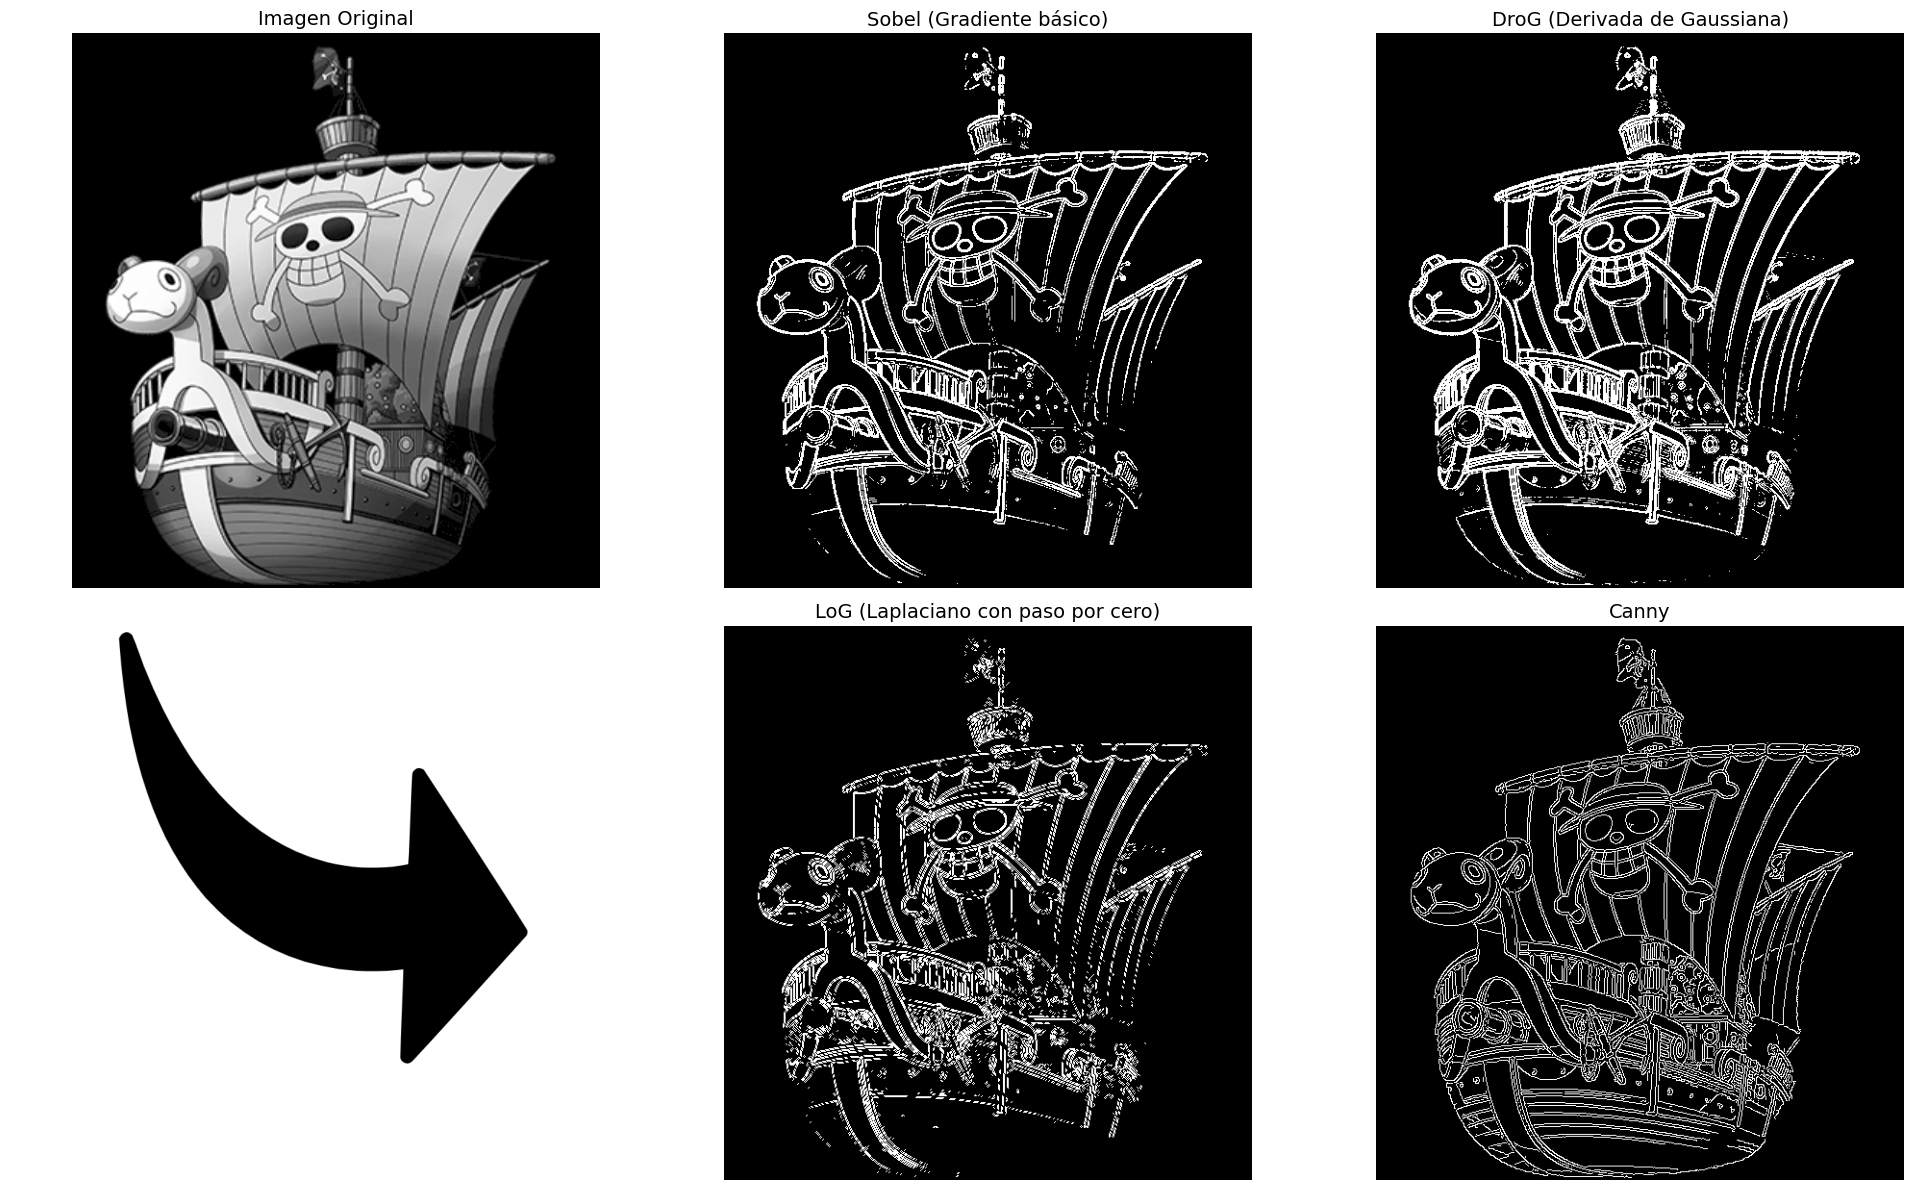

In [ ]:

def test_all_algorithms(image_path):
    # Cargamos la imagen
    image = cv2.imread(image_path, 0)
    
    # Definimos Sobel
    sobel_h = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_v = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    # Aplicamos todos los algoritmos
    edges_sobel = edge_detection_chart(image, sobel_h, sobel_v, threshold = 60)
    edges_drog = drog_kernel(image, w_kernel = 4, sigma = 0.4, threshold = 40)
    edges_log_zero_crossing = zero_crossing(image, size_Laplacian=7, sigma=3, w_gaussian=1, threshold=17)
    edges_canny = canny_testing(image, lower_threshold = 80, upper_threshold = 140, sigma = 1.5, w_gaussian = 2)

    # Creamos el subplot
    plt.figure(figsize=(20, 12))
    
    # Imagen original
    plt.subplot(2, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Imagen Original', fontsize=14)
    plt.axis('off')

    # Flecha
    plt.subplot(2, 3, 4)
    plt.imshow(cv2.imread(images_path + 'arrow2.png', 0), cmap='gray')
    plt.axis('off')
    
    # Gradiente con Sobel
    plt.subplot(2, 3, 2)
    plt.imshow(edges_sobel, cmap='gray')
    plt.title('Sobel (Gradiente básico)', fontsize=14)
    plt.axis('off')
    
    # Operador DroG
    plt.subplot(2, 3, 3)
    plt.imshow(edges_drog, cmap='gray')
    plt.title('DroG (Derivada de Gaussiana)', fontsize=14)
    plt.axis('off')
    
    # Operador LoG + Paso por cero
    plt.subplot(2, 3, 5)
    plt.imshow(edges_log_zero_crossing, cmap='gray')
    plt.title('LoG (Laplaciano con paso por cero)', fontsize=14)
    plt.axis('off')
    
    # Operador Canny
    plt.subplot(2, 3, 6)
    plt.imshow(edges_canny, cmap='gray')
    plt.title('Canny', fontsize=14)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test all algorithms with Barco.png
test_all_algorithms(images_path + 'Barco.png')

Analizando estos resultados y, como hemos visto en clase, el **algoritmo de Canny** da el mejor resultado, aproximando con mucha **precisión** y **sensibilidad**, ya que detecta correctamente la mayoría de bordes y suprime los falsos positivos.

## Implementación del resultado

A partir de la conclusión que hemos sacado de las pruebas previas, vamos a aplicar el **algoritmo de Canny** con esos hiperparámetros a las imágenes que tenemos.

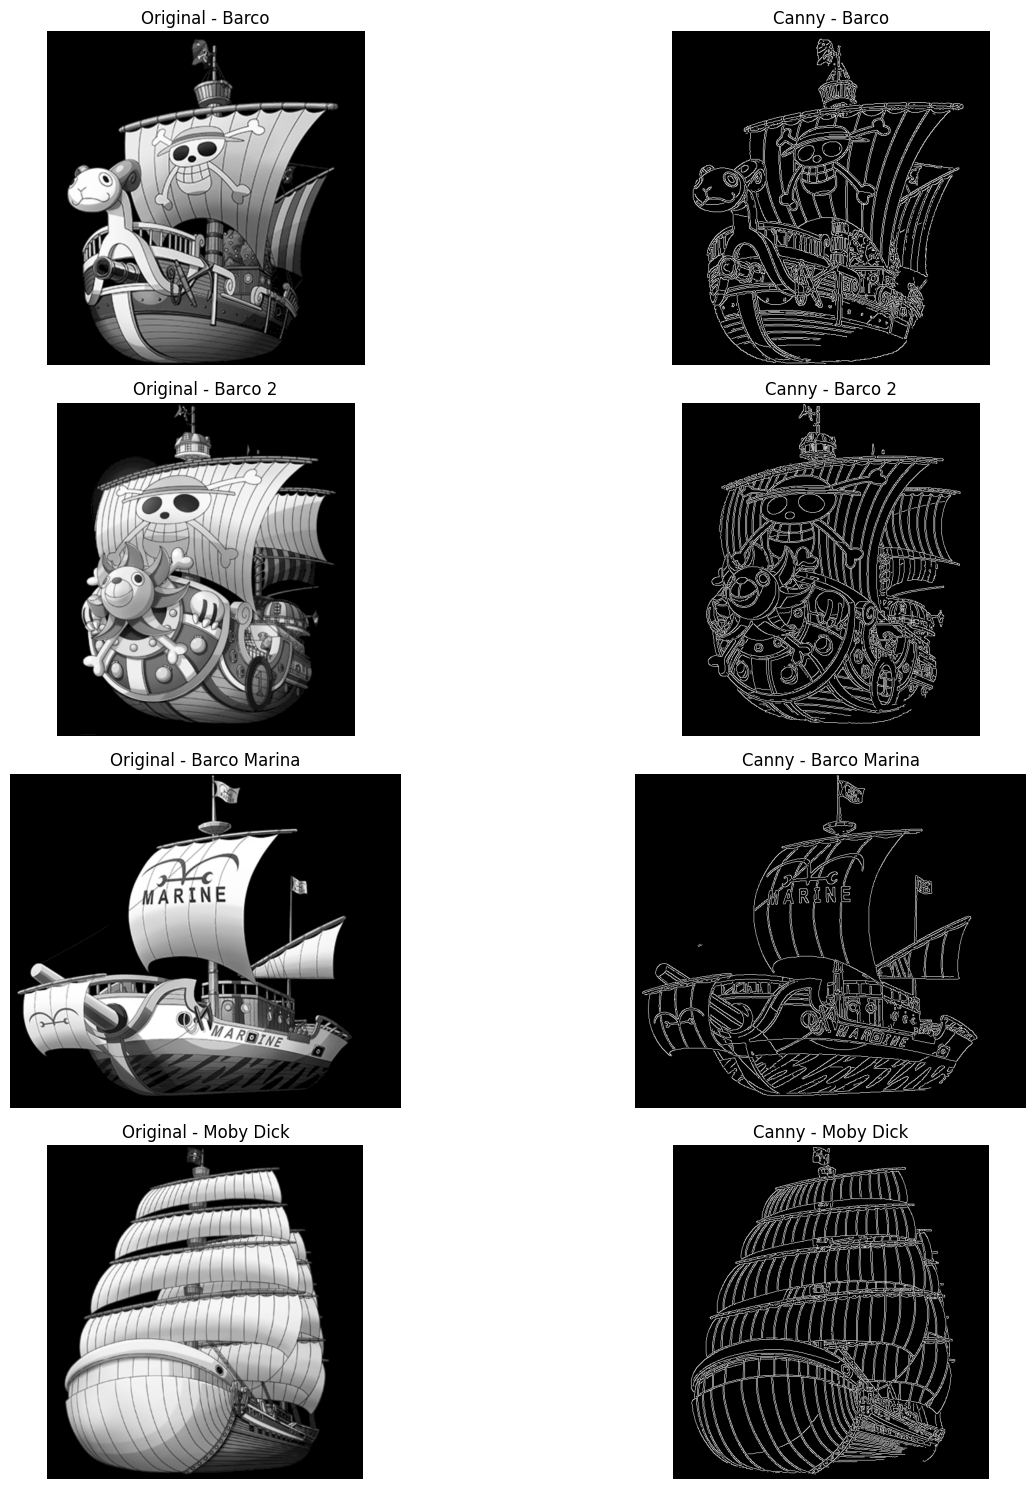

In [ ]:
def test_all_photos():
    # Cargamos las imágenes
    image1 = cv2.imread(images_path + 'Barco.png', 0)
    image2 = cv2.imread(images_path + 'Barco 2.png', 0)
    image3 = cv2.imread(images_path + 'Barco Marina.png', 0)
    image4 = cv2.imread(images_path + 'Moby Dick.png', 0)
    
    # Aplicamos SOLO la configuración de Canny (80-140)
    edges_image1 = canny_testing(image1, lower_threshold=80, upper_threshold=140, sigma=1.5, w_gaussian=2)
    edges_image2 = canny_testing(image2, lower_threshold=80, upper_threshold=140, sigma=1.5, w_gaussian=2)
    edges_image3 = canny_testing(image3, lower_threshold=80, upper_threshold=140, sigma=1.5, w_gaussian=2)
    edges_image4 = canny_testing(image4, lower_threshold=80, upper_threshold=140, sigma=1.5, w_gaussian=2)
    
    plt.figure(figsize=(20, 12))

    # Imagen 1 - Original y Canny
    plt.subplot(4, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.title('Original - Barco', fontsize=12)
    plt.axis('off')

    plt.subplot(4, 2, 2)
    plt.imshow(edges_image1, cmap='gray')
    plt.title('Canny - Barco', fontsize=12)
    plt.axis('off')

    # Imagen 2 - Original y Canny
    plt.subplot(4, 2, 3)
    plt.imshow(image2, cmap='gray')
    plt.title('Original - Barco 2', fontsize=12)
    plt.axis('off')

    plt.subplot(4, 2, 4)
    plt.imshow(edges_image2, cmap='gray')
    plt.title('Canny - Barco 2', fontsize=12)
    plt.axis('off')

    # Imagen 3 - Original y Canny
    plt.subplot(4, 2, 5)
    plt.imshow(image3, cmap='gray')
    plt.title('Original - Barco Marina', fontsize=12)
    plt.axis('off')

    plt.subplot(4, 2, 6)
    plt.imshow(edges_image3, cmap='gray')
    plt.title('Canny - Barco Marina', fontsize=12)
    plt.axis('off')

    # Imagen 4 - Original y Canny
    plt.subplot(4, 2, 7)
    plt.imshow(image4, cmap='gray')
    plt.title('Original - Moby Dick', fontsize=12)
    plt.axis('off')

    plt.subplot(4, 2, 8)
    plt.imshow(edges_image4, cmap='gray')
    plt.title('Canny - Moby Dick', fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

test_all_photos()